In [55]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import applications
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Dropout
import os
from matplotlib import pyplot as plt
from skimage.io import imread
import splitfolders 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

## For faster computation we make sure we start tensorflow GPU session. The below peice of code starts the session

In [57]:
import tensorflow as tf
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

## to check if gpu is running

In [58]:
tf.test.is_built_with_cuda()

True

## Now we display few images of dogs to see what our data looks like

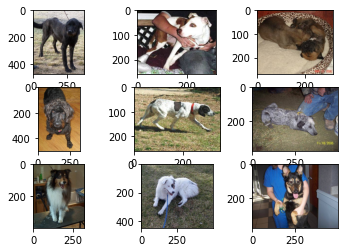

In [59]:

img_dir="Zoo Classifier project - images\images\dogs"
all_files=os.listdir(img_dir)
data_path = [os.path.join(img_dir + "/" + i) for i in all_files]
k=0
for i in data_path:
    if k <9:
        k=k+1
        plt.subplot(3,3,k) 
        plt.imshow(imread(i))
plt.show()

### We can see that some photos are landscape format, some are portrait format, and some are square. Also the size of images are different. So we would later require to resize them to the same size while computing 



### Next we split the data into train and test set subfolders and store it in a new directory. We split it as 80-20 percent (2400 train images and 600 test), this library makes sure each class images are equally divided.

In [60]:
#!pip install split-folders
input_folder = "Zoo Classifier project - images\images"
output = "all_animals"
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) 

Copying files: 3000 files [00:13, 214.81 files/s]


### Since we have very minimal data (1000 images per class), we need to augment our data so that  our model could never see precisely the same picture two times. data augmentation  adopts the strategy of creating additional training information from existing  train examples by augmenting the examples through various arbitrary changes that yield convincing looking pictures. This assists the model with getting presented to more parts of the information and sum up better. 

#### Here we use- 
rotation_range=10 (to rotate the image with max 10 degrees) \
width_shift_range=0.2 (to shift the width of image in range 0 to 0.2 percent) \
height_shift_range=0.2 (to shift the height of image in range 0 to 0.2 percent) \
horizontal_flip=True (to allow horizontal flip to the image) \
vertical_flip=True (to allow vertical flip to the image) \
zoom_range=0.1 (to zoom the image by max 0.1 percent) \
brightness_range=[0.5,1] (to shift the brightness of image in range 0.5 to 1) \
fill_mode = 'nearest' (This is specified in the fill_mode argument and the default value is “nearest” which simply replaces the empty area with the nearest pixel values) \
validation_split=0.2 (to split the train dataset to 80-20. 80% for train and 20% for validation)

### After which we use flow_from_directory where we can set the target size(for reshaping the data),size of the batches of data (batch_size), class_model(categorical for 2-D one hot encoded labels), color_mode to set rgb for our colored images 

In [61]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(#rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   horizontal_flip=True, 
                                   vertical_flip=True,
                                   zoom_range=0.1,
                                   brightness_range=[0.5,1],
                                   fill_mode = 'nearest',
                                   validation_split=0.2
)
train_generator=train_datagen.flow_from_directory(
    'all_animals/train',
    target_size=(200,200),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    subset='training',
    seed=100
)
validation_generator=train_datagen.flow_from_directory(
    'all_animals/train',
    target_size=(200,200),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    subset='validation',
    seed=100
)

Found 1920 images belonging to 3 classes.
Found 480 images belonging to 3 classes.


## displaying random augmented images to verify if data augmentation worked.
## Here we can see that images are flipped and their width and height are shifted.

Found 2400 images belonging to 3 classes.


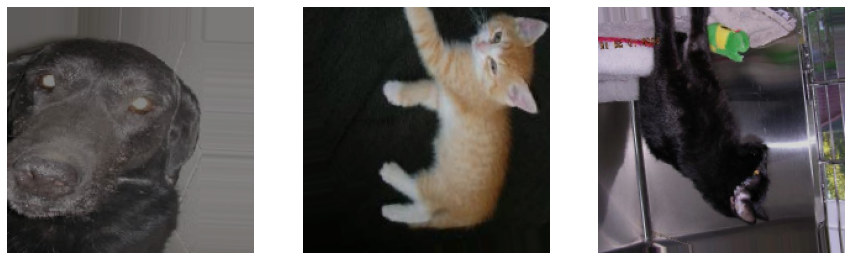

In [62]:
aug_iter = train_datagen.flow_from_directory(
    'all_animals/train',
    target_size=(200,200),
    color_mode='rgb',
    class_mode='categorical',
    seed=20,
    batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(3):

# convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')
    image = np.squeeze(image)
 
    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')

## Custom CNN model

### we use conv2D+ MaxPooling2D in our network as it augments the capacity of the network and helps in reducing the size of the feature maps. Which will help in the flatten layer.  BatchNormalization layer normalizes its output using the mean and standard deviation of the current batch of inputs. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.

### Since we are solving a classification problem, we are ending the network with a Dense layer of size 3 (computation for each class) and a softmax activation (for  vector of probabilities for multi-class classification)

In [63]:
model1=models.Sequential()
model1.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(200, 200, 3)))
model1.add(layers.Conv2D(32, (3,3), activation="relu"))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2,2)))

model1.add(layers.Conv2D(64, (3,3), activation="relu"))
model1.add(layers.Conv2D(64, (3,3), activation="relu"))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(2,2))
model1.add(layers.Dropout(0.25))

model1.add(layers.Conv2D(128, (3,3), activation="relu"))
model1.add(layers.Conv2D(128, (3,3), activation="relu"))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Conv2D(64, (3,3), activation="relu"))
model1.add(layers.Conv2D(64, (3,3), activation="relu"))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Dropout(0.25))
model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation="relu"))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(3, activation="softmax"))
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 conv2d_26 (Conv2D)          (None, 196, 196, 32)      9248      
                                                                 
 batch_normalization_12 (Bat  (None, 196, 196, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 98, 98, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 conv2d_28 (Conv2D)          (None, 94, 94, 64)       

### for compilation we use Adam optimizer and categorical_crossentropy for our multi-class classification model)

In [64]:
model1.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epochs are the number of forward/backward passes of the training data.

Steps_per_epoch is an important argument. It specifies the number of batches of images that are in a single epoch. It is usually taken as the length of the original dataset divided by the batch size (1920/64=30)

Validation_data takes the validation dataset or the validation generator output from the generator method.

Validation_steps is similar to steps_per_epoch, but for validation data. This can be used when you are augmenting the validation set images as well.(480/64=8)

In [65]:
history1 = model1.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    verbose=1,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(validation_generator)
                    )

C:\Users\rudra\AppData\Local\Temp/ipykernel_22580/447157333.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model1.fit_generator(train_generator,


Epoch 1/100
30/30 [==============================] - 124s 4s/step - loss: 2.2216 - accuracy: 0.4875 - val_loss: 15.7003 - val_accuracy: 0.3333
Epoch 2/100
30/30 [==============================] - 119s 4s/step - loss: 1.3073 - accuracy: 0.5443 - val_loss: 1.5959 - val_accuracy: 0.3979
Epoch 3/100
30/30 [==============================] - 120s 4s/step - loss: 0.9298 - accuracy: 0.5839 - val_loss: 1.5233 - val_accuracy: 0.3146
Epoch 4/100
30/30 [==============================] - 119s 4s/step - loss: 0.8641 - accuracy: 0.6042 - val_loss: 2.5964 - val_accuracy: 0.3604
Epoch 5/100
30/30 [==============================] - 119s 4s/step - loss: 0.7862 - accuracy: 0.6151 - val_loss: 1.8489 - val_accuracy: 0.4271
Epoch 6/100
30/30 [==============================] - 119s 4s/step - loss: 0.7991 - accuracy: 0.6177 - val_loss: 1.0547 - val_accuracy: 0.4313
Epoch 7/100
30/30 [==============================] - 120s 4s/step - loss: 0.7432 - accuracy: 0.6323 - val_loss: 1.6777 - val_accuracy: 0.3833
Epoch

### now we save our model

In [78]:
model1.save('zoo_classifier1.h5')

### Final Accuracy and loss values after 100 epochs

In [84]:
acc = history1.history['accuracy'][-1]
val_acc = history1.history['val_accuracy'][-1]
loss = history1.history['loss'][-1]
val_loss = history1.history['val_loss'][-1]

print('Train accuracy:', acc)
print('Validation accuracy:', val_acc)
print('Train loss:', loss)
print('Validation loss:', val_loss)

Train accuracy: 0.8458333611488342
Validation accuracy: 0.6937500238418579
Train loss: 0.35369765758514404
Validation loss: 0.7099759578704834


### Plot of accuracy vs validation accuracy

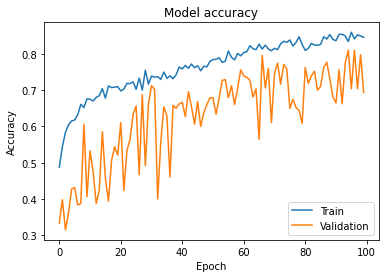

In [66]:
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### Plot of train loss vs validation loss

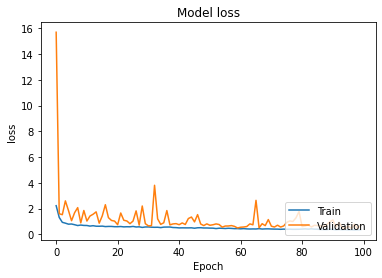

In [67]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

## VGG16 and ResNet50

### VGG16
VGG16 is a simple and widely used Convolutional Neural Network (CNN). The VGG16 Architecture was developed and introduced by Karen Simonyan and Andrew Zisserman, through their article “Very Deep Convolutional Networks for Large-Scale Image Recognition.” ‘VGG’ is the abbreviation for Visual Geometry Group, ‘16’ implies that this architecture has 16 layers (explained later).
The VGG16 model achieved 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.


### ResNet50
ResNet-50 is a convolutional neural network that is 50 layers deep. It is a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. 

### Transfer learning
Usuing these two pretained models we perform transfer learning. Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

The workflow for transfer learning is:

1) Take layers from a previously trained model. \
2) Freeze them, so as to avoid destroying any of the information they contain during future training rounds.\
3) Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.\
4) Train the new layers on your dataset.

In [68]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from keras import Model
from keras.layers import Flatten, Dense
def vg_model_build(shape):
    model=VGG16(input_shape=shape,include_top=False)
    for layer in model.layers:
        layer.trainable = False
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation="relu", kernel_initializer="he_uniform")(flat1)
    class2 = Dense(62, activation="relu", kernel_initializer="he_uniform")(class1)
    output = Dense(3, activation="softmax")(class1)
    model1 = Model(inputs=model.inputs, outputs=output)
    model1.compile(optimizer='Adam',loss="categorical_crossentropy", metrics=["accuracy"])
    return model1
def rn_model_build(shape):
    model = tf.keras.models.Sequential([
        ResNet50(input_shape=shape, include_top=False),
    ])
    for layer in model.layers:
      layer.trainable = False

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model
vg_model = vg_model_build((200,200,3))
rn_model = rn_model_build((200,200,3))

In [69]:
history2 = vg_model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    verbose=1,
                    steps_per_epoch=30,
                    validation_steps=8
                    )

C:\Users\rudra\AppData\Local\Temp/ipykernel_22580/3370754336.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = vg_model.fit_generator(train_generator,


Epoch 1/100
30/30 [==============================] - 106s 4s/step - loss: 7.3151 - accuracy: 0.7063 - val_loss: 0.9545 - val_accuracy: 0.8313
Epoch 2/100
30/30 [==============================] - 105s 4s/step - loss: 0.6247 - accuracy: 0.8573 - val_loss: 0.6311 - val_accuracy: 0.8479
Epoch 3/100
30/30 [==============================] - 112s 4s/step - loss: 0.4642 - accuracy: 0.8760 - val_loss: 0.4971 - val_accuracy: 0.8813
Epoch 4/100
30/30 [==============================] - 106s 4s/step - loss: 0.3444 - accuracy: 0.8979 - val_loss: 0.3873 - val_accuracy: 0.8562
Epoch 5/100
30/30 [==============================] - 103s 3s/step - loss: 0.3255 - accuracy: 0.8964 - val_loss: 0.3813 - val_accuracy: 0.8604
Epoch 6/100
30/30 [==============================] - 103s 3s/step - loss: 0.3015 - accuracy: 0.9078 - val_loss: 0.3334 - val_accuracy: 0.8813
Epoch 7/100
30/30 [==============================] - 107s 4s/step - loss: 0.2794 - accuracy: 0.9036 - val_loss: 0.3137 - val_accuracy: 0.8667
Epoch 

### now we save our model

In [85]:
vg_model.save('zoo_classifier2.h5')

### Final Accuracy and loss values after 100 epochs

In [86]:
acc = history2.history['accuracy'][-1]
val_acc = history2.history['val_accuracy'][-1]
loss = history2.history['loss'][-1]
val_loss = history2.history['val_loss'][-1]

print('Train accuracy:', acc)
print('Validation accuracy:', val_acc)
print('Train loss:', loss)
print('Validation loss:', val_loss)

Train accuracy: 0.9781249761581421
Validation accuracy: 0.9104166626930237
Train loss: 0.06955906003713608
Validation loss: 0.37280362844467163


### Plot of accuracy vs validation accuracy

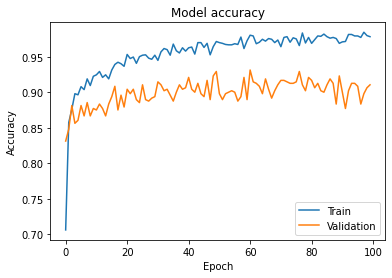

In [70]:
import matplotlib.pyplot as plt
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### Plot of train loss vs validation loss

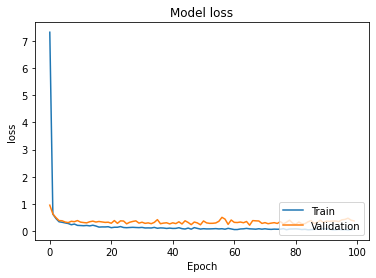

In [71]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [72]:
history3 = rn_model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    verbose=1,
                    steps_per_epoch=30,
                    validation_steps=8
                    )

C:\Users\rudra\AppData\Local\Temp/ipykernel_22580/272749727.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = rn_model.fit_generator(train_generator,


Epoch 1/100
30/30 [==============================] - 77s 3s/step - loss: 1.8032 - accuracy: 0.6646 - val_loss: 0.3952 - val_accuracy: 0.8417
Epoch 2/100
30/30 [==============================] - 74s 2s/step - loss: 0.4577 - accuracy: 0.8417 - val_loss: 0.2458 - val_accuracy: 0.8979
Epoch 3/100
30/30 [==============================] - 73s 2s/step - loss: 0.3147 - accuracy: 0.8828 - val_loss: 0.2209 - val_accuracy: 0.9104
Epoch 4/100
30/30 [==============================] - 73s 2s/step - loss: 0.2834 - accuracy: 0.8917 - val_loss: 0.3915 - val_accuracy: 0.8729
Epoch 5/100
30/30 [==============================] - 77s 3s/step - loss: 0.2458 - accuracy: 0.9078 - val_loss: 0.2397 - val_accuracy: 0.9042
Epoch 6/100
30/30 [==============================] - 74s 2s/step - loss: 0.2278 - accuracy: 0.9156 - val_loss: 0.2675 - val_accuracy: 0.9187
Epoch 7/100
30/30 [==============================] - 75s 2s/step - loss: 0.2423 - accuracy: 0.9042 - val_loss: 0.2189 - val_accuracy: 0.9042
Epoch 8/100
3

### now we save our model

In [87]:
rn_model.save('zoo_classifier3.h5')

### Final Accuracy and loss values after 100 epochs

In [88]:
acc = history3.history['accuracy'][-1]
val_acc = history3.history['val_accuracy'][-1]
loss = history3.history['loss'][-1]
val_loss = history3.history['val_loss'][-1]

print('Train accuracy:', acc)
print('Validation accuracy:', val_acc)
print('Train loss:', loss)
print('Validation loss:', val_loss)

Train accuracy: 0.9864583611488342
Validation accuracy: 0.9541666507720947
Train loss: 0.041410014033317566
Validation loss: 0.2846871316432953


### Plot of accuracy vs validation accuracy

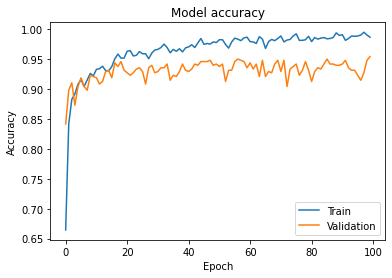

In [73]:
import matplotlib.pyplot as plt
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### Plot of train loss vs validation loss

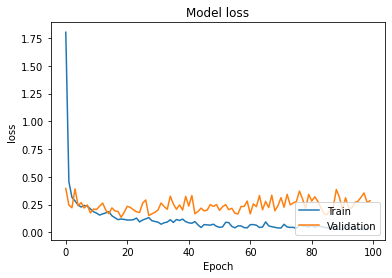

In [74]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### Model Comparison

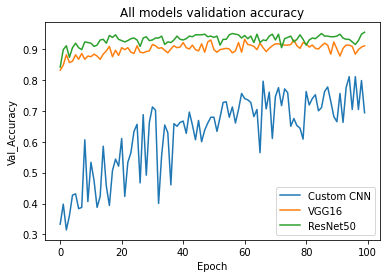

In [89]:
import matplotlib.pyplot as plt
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('All models validation accuracy')
plt.ylabel('Val_Accuracy')
plt.xlabel('Epoch')
plt.legend(['Custom CNN','VGG16','ResNet50'], loc='lower right')
plt.show()

## From the above graph we can see both VGG16 and ResNet50 perform really well. Out of these two Resent50 has a better validation accuracy

In [ ]:
## Now we evaluate the three models on unseen data and compare them through confusion matrix

In [133]:
test_datagen=ImageDataGenerator()
test_data = test_datagen.flow_from_directory('all_animals/val',
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        target_size=(200,200),
                                        shuffle=False,
                                        seed=100)
test_pred1 = model1.predict(test_data)
test_pred2 = vg_model.predict(test_data)
test_pred3 = rn_model.predict(test_data)

Found 600 images belonging to 3 classes.


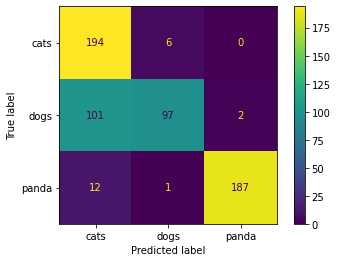

In [134]:
from numpy import argmax
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score

predictions1 = argmax(test_pred1, axis=1) # return to label
true_label = test_data.classes

ConfusionMatrixDisplay(confusion_matrix(true_label, predictions1), display_labels=test_data.class_indices).plot();

## Custom CNN does not do so well at classifying dogs correctly as  ore than half of the testing data dogs were classified as cats

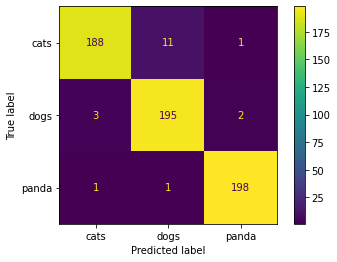

In [135]:
from numpy import argmax
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score

predictions2 = argmax(test_pred2, axis=1) # return to label
true_label = test_data.classes

ConfusionMatrixDisplay(confusion_matrix(true_label, predictions2), display_labels=test_data.class_indices).plot();

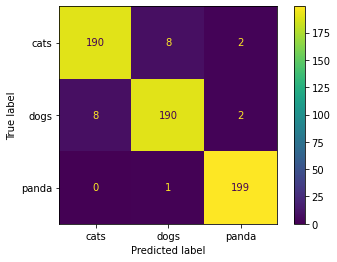

In [136]:
from numpy import argmax
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score

predictions3 = argmax(test_pred3, axis=1) # return to label
true_label = test_data.classes

ConfusionMatrixDisplay(confusion_matrix(true_label, predictions3), display_labels=test_data.class_indices).plot();

## As we can see both VGG16 and ResNet50 classify the images quite well. Their classifying accuracies are quite similar.

# Now we load the resnet saved model and test it on some unseen data to see if it classifies those new images properly

Found 600 images belonging to 3 classes.
Predicted label : cat
Predicted label : cat
Predicted label : cat


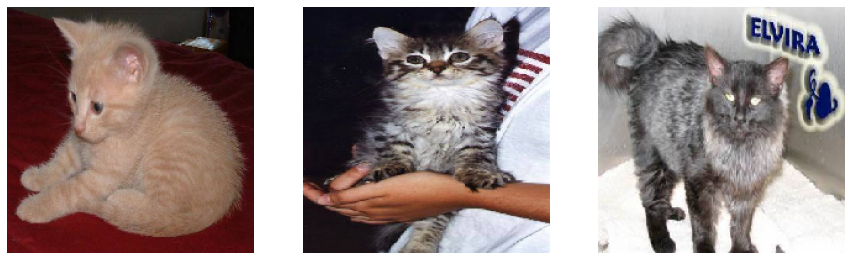

In [132]:
import tensorflow
loaded_model = tensorflow.keras.models.load_model("zoo_classifier3.h5")
test_datagen=ImageDataGenerator()
test_data = test_datagen.flow_from_directory('all_animals/val',
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        target_size=(200,200),
                                        shuffle=False,
                                        batch_size=1,
                                        seed=100)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for i in range(3):
    pred = loaded_model.predict(test_data)
    if (pred[0][0] > pred[0][1] and pred[0][0] > pred[0][2]):
                print("Predicted label : cat")
    if (pred[0][1] > pred[0][0] and pred[0][1] > pred[0][2]):
                print("Predicted label : dog")
    if (pred[0][2] > pred[0][0] and pred[0][2] > pred[0][1]):
                print("Predicted label : panda")
    image = next(test_data)[0].astype('uint8')
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis('off')
